# *** Compare SFR stages Vs RIV stages ***

- RIV stage comes from the RIV IDF files that were given to us by Deltares.
- Sys 1: DETAILWATERGANGEN (contains the detailed network) will be used for the calculations. The other systems are mostly/completely absent in our region of interest. For proof of that, check ./SFRstage_Vs_RIVstage_NBr43.ipynb 

# 0. Initial

## 0.0. Imports

In [1]:
import imod

In [2]:
import WS_Mdl.utils as U
import WS_Mdl.utils_imod as UIM
import WS_Mdl.calcs as C
import WS_Mdl.geo as G

In [143]:
import importlib as IL
IL.reload(U)
IL.reload(UIM)
IL.reload(G)

<module 'WS_Mdl.geo' from 'G:\\code\\WS_Mdl\\geo.py'>

In [4]:
import os
from os import listdir as LD, makedirs as MDs
from os.path import join as PJ, basename as PBN, dirname as PDN, exists as PE
import shutil as sh
import pandas as pd
from datetime import datetime as DT
import matplotlib.pyplot as plt
from pathlib import Path
import re
import xarray as xr

In [156]:
import plotly.graph_objects as go

## 0.1. Options

In [6]:
U.set_verbose(False)

In [7]:
MdlN = 'NBr47'
MdlN_RIV = 'NBr43'

In [8]:
# Load paths and variables from PRJ & INI
d_Pa = U.get_MdlN_Pa(MdlN)
Pa_PRJ = d_Pa['PRJ']
Dir_PRJ = PDN(Pa_PRJ)
d_INI = U.INI_to_d(d_Pa['INI'])
Xmin, Ymin, Xmax, Ymax, cellsize, N_R, N_C = U.Mdl_Dmns_from_INI(d_Pa['INI'])
SP_date_1st, SP_date_last = [DT.strftime(DT.strptime(d_INI[f'{i}'], '%Y%m%d'), '%Y-%m-%d') for i in ['SDATE', 'EDATE']]
dx = dy = float(d_INI['CELLSIZE'])

In [9]:
# Load paths and variables from PRJ & INI
d_Pa_RIV = U.get_MdlN_Pa(MdlN_RIV)
Pa_PRJ_RIV = d_Pa_RIV['PRJ']
Dir_PRJ_RIV = PDN(Pa_PRJ_RIV)
d_INI_RIV = U.INI_to_d(d_Pa_RIV['INI'])

In [10]:
if (Xmin, Ymin, Xmax, Ymax, cellsize, N_R, N_C) != U.Mdl_Dmns_from_INI(d_Pa_RIV['INI']):
    print("Warning: Model dimensions for RIV model differ from main model.")

In [11]:
SP_date_1st_RIV, SP_date_last_RIV = [DT.strftime(DT.strptime(d_INI_RIV[f'{i}'], '%Y%m%d'), '%Y-%m-%d') for i in ['SDATE', 'EDATE']]

# 1. Load Stuff

## 1.0. Load PRJ

In [12]:
PRJ, PRJ_OBS = UIM.r_PRJ_with_OBS(Pa_PRJ)

## 1.1. Load SFR

d_Pa.keys()

In [58]:
d_Pa.keys()

dict_keys(['imod_V', 'Mdl', 'MdlN', 'Pa_Mdl', 'Smk_temp', 'In', 'PoP', 'code', 'pixi', 'coupler_Exe', 'MF6_DLL', 'MSW_DLL', 'INI', 'BAT', 'PRJ', 'Smk', 'Sim', 'Pa_MdlN', 'MF6', 'MSW', 'TOML', 'TOML_iMOD5', 'LST_Sim', 'LST_Mdl', 'NAM_Sim', 'NAM_Mdl', 'Sim_In', 'Sim_Out', 'SFR', 'Out_HD', 'Out_HD_Bin', 'DIS_GRB', 'PoP_Out_MdlN', 'MM'])

In [63]:
def get_SFR_OBS_Out_Pas(MdlN, filetype='.csv'):
    d_Pa = U.get_MdlN_Pa(MdlN)
    l_Pa = [PJ(d_Pa['Sim_In'], i) for i in os.listdir(d_Pa['Sim_In']) if 'SFR' in i.upper() and 'OBS' in i.upper() and i.lower().endswith(filetype)]
    if len(l_Pa) == 1:
        l_Pa = l_Pa[0]
    return l_Pa

In [13]:
# # Get SFR OBS path
# with open(d_Pa['SFR'], 'r') as f:
#     Pa_SFR_OBS = PJ(PDN(d_Pa['Sim_In']), str([i for i in f.readlines() if 'OBS6 FILEIN' in i][0]).replace('OBS6 FILEIN', '').strip().replace('\n', '') )

In [14]:
# # Get SFR OBS output path
# with open(Pa_SFR_OBS, 'r') as f:
#     Pa_SFR_Out = str([i for i in f.readlines() if 'BEGIN CONTINUOUS FILEOUT' in i][0]).replace('BEGIN CONTINUOUS FILEOUT', '').strip().replace('\n', '')

In [65]:
get_SFR_OBS_Out_Pas(MdlN)

['G:/models/NBr\\Sim/NBr47\\modflow6/imported_model\\Copy (2) NBr47.SFR6.obs.output.csv',
 'G:/models/NBr\\Sim/NBr47\\modflow6/imported_model\\NBr47.SFR6.obs.output.csv',
 'G:/models/NBr\\Sim/NBr47\\modflow6/imported_model\\NBr47.SFR6.obs.output_.csv']

In [93]:
DF = pd.read_csv(get_SFR_OBS_Out_Pas(MdlN)[1]) # 666 replace 1. This needs to be standardized.

In [94]:
DF = DF[[i for i in DF.columns if i=='time' or 'L' in i]]

In [95]:
DF['time'] = pd.to_datetime(SP_date_1st) + pd.to_timedelta(DF['time']-1, unit='D')

In [96]:
DF.head()

,time,L5_R291_C366,L5_R290_C365,L5_R290_C364,L5_R289_C364,L5_R289_C363,L5_R288_C363,L5_R288_C362,L5_R287_C362,L5_R287_C361,...,L3_R13_C422,L3_R13_C423,L1_R12_C423,L1_R12_C424,L3_R12_C425,L3_R12_C426,L3_R12_C427,L3_R11_C427,L3_R11_C428,L3_R11_C429
0,1993-01-01,18.902,18.904,18.905,18.904,18.904,18.903,18.900,18.9,18.9,...,15.835,15.835,15.835,15.835,15.835,15.835,15.835,15.835,15.835,15.835
1,1993-01-02,18.902,18.904,18.905,18.904,18.904,18.903,18.901,18.9,18.9,...,15.835,15.835,15.835,15.835,15.835,15.835,15.835,15.835,15.835,15.835
2,1993-01-03,18.902,18.904,18.904,18.904,18.904,18.903,18.900,18.9,18.9,...,15.835,15.835,15.835,15.835,15.835,15.835,15.835,15.835,15.835,15.835
3,1993-01-04,18.902,18.904,18.904,18.904,18.903,18.902,18.900,18.9,18.9,...,15.835,15.835,15.835,15.835,15.835,15.835,15.835,15.835,15.835,15.835
4,1993-01-05,18.902,18.904,18.904,18.904,18.903,18.902,18.900,18.9,18.9,...,15.835,15.835,15.835,15.835,15.835,15.835,15.835,15.835,15.835,15.835


GDF_SFR.describe()

In [56]:
U.set_verbose(False)
GDF_SFR = U.SFR_PkgD_to_DF(MdlN)
GDF_SFR

,rno,k,i,j,Cond,rlen,rwid,rgrd,rtp,rbth,rhk,man,ncon,ustrf,ndv,line_id,X,Y
0,1,5,291,366,24.999999,32.71004,1.0,0.0001,18.899851,0.1,0.076429,0.037,1,1,0,7711,122237.5,388937.5
1,2,5,290,365,25.0,33.563854,1.0,0.0001,18.899851,0.1,0.074485,0.037,2,1,0,7711,122212.5,388962.5
2,3,5,290,364,5.0,3.111411,1.0,0.0001,18.899851,0.1,0.160699,0.037,2,1,0,7711,122187.5,388962.5
3,4,5,289,364,20.0,30.346876,1.0,0.0001,18.899851,0.1,0.065905,0.037,2,1,0,7711,122187.5,388987.5
4,5,5,289,363,10.0,7.194803,1.0,0.0001,18.899851,0.1,0.138989,0.037,2,1,0,7711,122162.5,388987.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23888,23889,3,12,426,25.687094,25.687094,1.0,0.0001,15.835,0.1,0.1,0.037,2,1,0,12432,123737.5,395912.5
23889,23890,3,12,427,21.43659,21.43659,1.0,0.0001,15.835,0.1,0.1,0.037,2,1,0,12432,123762.5,395912.5
23890,23891,3,11,427,4.508092,4.508092,1.0,0.0001,15.835,0.1,0.1,0.037,2,1,0,12432,123762.5,395937.5
23891,23892,3,11,428,26.427288,26.427288,1.0,0.0001,15.835,0.1,0.1,0.037,2,1,0,12432,123787.5,395937.5


In [19]:
GDF_SFR.describe()

,rno,k,i,j,Cond,rlen,rwid,rgrd,rtp,rbth,rhk,man,ncon,ustrf,ndv,line_id,X,Y
count,23893.0,23893.0,23893.0,23893.0,23893.0,23893.0,23893.0,23893.0,23893.0,23893.0,23893.0,23893.0,23893.0,23893.0,23893.0,23893.0,23893.0,23893.0
mean,11947.0,5.563345,145.924748,225.424978,34.675862,19.22195,2.082224,0.007683,10.504683,0.1,0.138799,0.037,1.979492,1.0,0.0,25791.966685,118723.124451,392564.381304
std,6897.459327,3.21564,87.409004,132.170189,553.022368,8.731704,30.970471,0.046629,4.601555,0.0,0.181936,0.0,0.381207,0.0,0.0,14866.786171,3304.254716,2185.225095
min,1.0,1.0,1.0,1.0,0.03585,1.251087,0.4,0.0001,-1.65,0.1,0.000825,0.037,0.0,1.0,0.0,968.0,113112.5,387612.5
25%,5974.0,3.0,73.0,120.0,10.84869,11.900869,1.0,0.0001,6.74,0.1,0.080246,0.037,2.0,1.0,0.0,16507.0,116087.5,390712.5
50%,11947.0,5.0,141.0,224.0,20.0,22.982475,1.0,0.0001,10.95,0.1,0.09957,0.037,2.0,1.0,0.0,21594.0,118687.5,392687.5
75%,17920.0,7.0,220.0,332.0,25.0,25.668823,1.0,0.000303,14.065001,0.1,0.123297,0.037,2.0,1.0,0.0,37801.0,121387.5,394387.5
max,23893.0,16.0,344.0,480.0,61139.350003,61.734882,999.0,1.0,23.222347,0.1,3.566169,0.037,9.0,1.0,0.0,60752.0,125087.5,396187.5


## 1.2. Load RIV

In [20]:
Pa_PRJ_RIV = d_Pa_RIV['PRJ']

In [21]:
PRJ_RIV, PRJ_OBS_RIV = UIM.r_PRJ_with_OBS(Pa_PRJ_RIV)

In [23]:
N_system = int(input(f"The model has {PRJ_RIV['(riv)']['n_system']} river systems. Select the number of the system you want to plot. (1-indexed)"))
if N_system<1 or N_system>PRJ_RIV['(riv)']['n_system']:
    print("Invalid system number.")

In [24]:
for i in PRJ_RIV['(riv)']['conductance']:
    print(i['path'])
    print(i['time'])

G:\models\NBr\In\RIV\RIV_Cond_DETAILWATERGANGEN_NBr1.IDF
1990-10-01 00:00:00
G:\models\NBr\In\RIV\RIV_Cond_RIV_NBr1.IDF
1990-10-01 00:00:00
G:\models\NBr\In\RIV\RIV_Cond_DRN_NBr1.IDF
1990-10-01 00:00:00
G:\models\NBr\In\RIV\RIV_Cond_Maas_NBr1.IDF
1990-10-01 00:00:00
G:\models\NBr\In\RIV\RIV_Cond_Polderpeil_NBr1.IDF
1990-10-01 00:00:00
G:\models\NBr\In\RIV\RIV_Cond_DETAILWATERGANGEN_NBr1.IDF
1990-04-01 00:00:00
G:\models\NBr\In\RIV\RIV_Cond_RIV_NBr1.IDF
1990-04-01 00:00:00
G:\models\NBr\In\RIV\RIV_Cond_DRN_NBr1.IDF
1990-04-01 00:00:00
G:\models\NBr\In\RIV\RIV_Cond_Maas_NBr1.IDF
1990-04-01 00:00:00
G:\models\NBr\In\RIV\RIV_Cond_Polderpeil_NBr1.IDF
1990-04-01 00:00:00


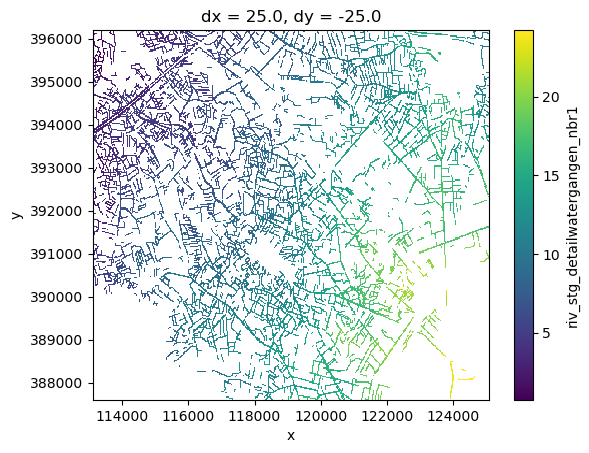

In [51]:
A_RIV_Stg= UIM.xr_clip_Mdl_Aa(imod.idf.open(PRJ_RIV['(riv)']['stage'][N_system-1]['path']), MdlN=MdlN)
A_RIV_Stg.plot()

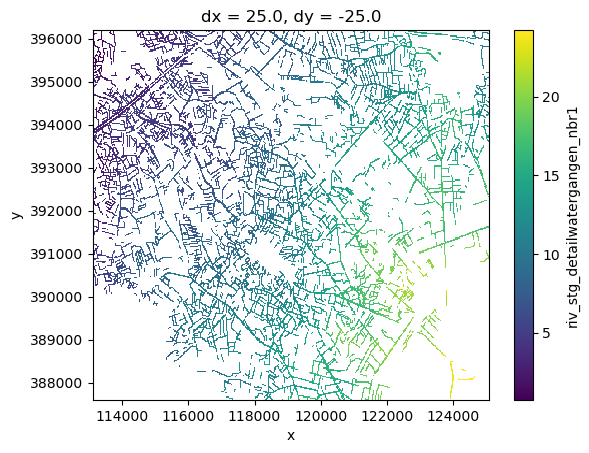

In [27]:
A_RIV_Btm= UIM.xr_clip_Mdl_Aa(imod.idf.open(PRJ_RIV['(riv)']['bottom_elevation'][N_system-1]['path']), MdlN=MdlN)
A_RIV_Btm.plot()

In [35]:
if A_RIV_Btm.notnull().sum().values == (A_RIV_Btm == A_RIV_Stg).sum().values:
    print('All river bottom elevations are equal to stage elevations.')

All river bottom elevations are equal to stage elevations.


## 1.3. Load TOP BOT

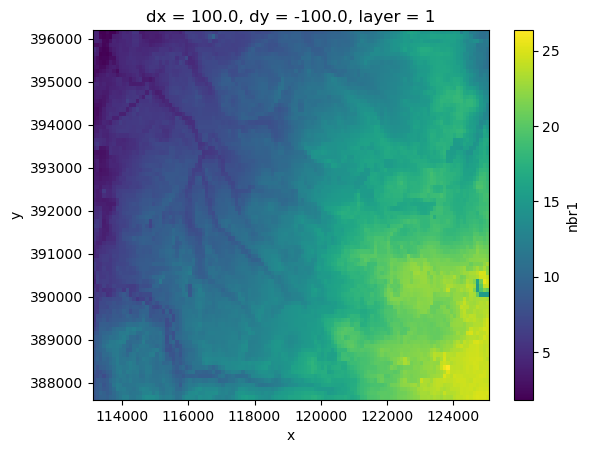

In [42]:
l_Pa_TOP = [i['path'] for i in PRJ['(top)']['top']]
A_TOP = UIM.xr_clip_Mdl_Aa(imod.idf.open(l_Pa_TOP, pattern=r'TOP_L{layer}_{name}'), MdlN=MdlN) # Use {name} to capture the model number part - imod will use it for the DataArray name. We're just doing this to avoid errors
# A_TOP.sel(layer=1).plot()

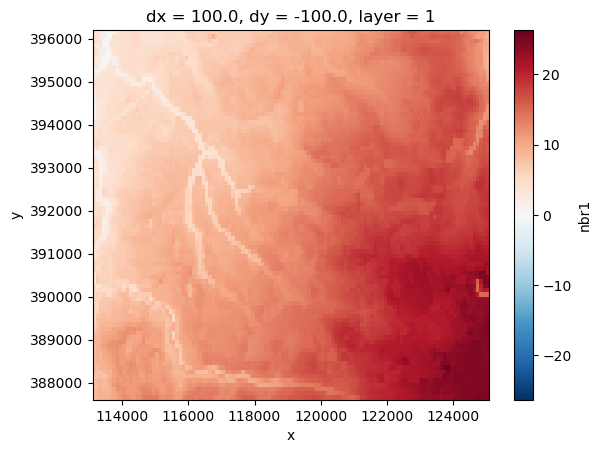

In [41]:
l_Pa_BOT = [i['path'] for i in PRJ['(bot)']['bottom']]
A_BOT = UIM.xr_clip_Mdl_Aa(imod.idf.open(l_Pa_BOT, pattern=r'BOT_L{layer}_{name}'), MdlN=MdlN)
# A_BOT.sel(layer=1).plot()

## 1.4. Load head

In [196]:
d_Pa['Out_HD_Bin']

'G:/models/NBr\\Sim/NBr47\\modflow6/imported_model\\imported_model.hds'

# 2. Load cell data and plot

In [192]:
def plot_SFR_reach_TS(reach, L, R, C, MdlN, SFR_Stg, RIV_Stg, RIV_Btm, top, Btm):
    """
    Plot SFR stage time series for a specific reach along with reference lines for river stage, river bottom, layer top, and layer bottom.
    """
    # Get the stage column name
    stg_col = f'L{L}_R{R}_C{C}'

    fig = go.Figure()

    # Create arrays with same length as time series for constant values
    n = len(SFR_Stg)
    riv_stg_arr = [RIV_Stg] * n
    riv_btm_arr = [RIV_Btm] * n
    top_arr = [top] * n
    btm_arr = [Btm] * n

    # Custom hover template with date and monospace font for alignment
    hover_template = (
        #'<b>%{x|%b %d, %Y}</b><br>'
        'SFR stage:    %{y:.3f}<br>'
        f'RIV stage:    {RIV_Stg:.3f}<br>'
        f'RIV bottom:   {RIV_Btm:.3f}<br>'
        f'Layer top:    {top:.3f}<br>'
        f'Layer bottom: {Btm:.3f}'
        '<extra></extra>'
    )

    # SFR stage TS
    fig.add_trace(go.Scatter( 
        x=SFR_Stg['time'], y=SFR_Stg[stg_col],
        mode='lines', name='SFR stage',
        line=dict(color='royalblue', width=2),
        hovertemplate=hover_template,
        showlegend=True
    ))

    # RIV - Horizontal reference lines (constant values) - no hover for these
    fig.add_trace(go.Scatter(
        x=SFR_Stg['time'], y=riv_stg_arr,
        mode='lines', name=f'RIV stage',
        line=dict(color='green', width=2, dash='dash'),
        hoverinfo='skip'
    ))

    fig.add_trace(go.Scatter(
        x=SFR_Stg['time'], y=riv_btm_arr,
        mode='lines', name=f'RIV bottom',
        line=dict(color='green', width=1),
        hoverinfo='skip'
    ))

    fig.add_trace(go.Scatter(
        x=SFR_Stg['time'], y=top_arr,
        mode='lines', name=f'L{L} top',
        line=dict(color="#945400", width=1),
        hoverinfo='skip'
    ))

    fig.add_trace(go.Scatter(
        x=SFR_Stg['time'], y=btm_arr,
        mode='lines', name=f'L{L} bottom',
        line=dict(color="#945400", width=1),
        hoverinfo='skip'
    ))

    fig.update_layout(
        title=dict(
            text=f'SFR Stage Time-Series - Reach {reach} (L{L}, R{R}, C{C}) - MdlN: {MdlN}',
            x=0.5,
            xanchor='center'
        ),
        xaxis_title='Time',
        yaxis_title='Elevation (m)',
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='center',
            x=0.5
        ),
        hovermode='x',
        hoverlabel=dict(
            namelength=0,  # Hide trace name completely
            bgcolor='white',
            bordercolor='gray',
            font=dict(family='Consolas, monospace')
        ),
        template='plotly_white',
        margin=dict(t=100),  # Extra top margin for legend
        xaxis=dict(
            showspikes=True,
            spikemode='across',
            spikesnap='cursor',
            spikecolor='gray',
            spikethickness=1,
            dtick='M1',  # Grid line every month
            showgrid=True,
            gridcolor='rgba(200, 200, 200, 0.5)',
            gridwidth=1
        ),
        yaxis=dict(
            showspikes=True,
            spikemode='across',
            spikesnap='cursor',
            spikecolor='gray',
            spikethickness=1
        )
    )

    fig.write_html('SFR_stage_plot.html', auto_open=True)

In [ ]:
import re

while True:
    i = input("Provide a cell ID (L R C) (with spaces or commas as separators) or a reach number. If you're providing a reach number, prefix it with 'R' (e.g., R15). Type 'exit' to quit:")

    U.vprint('- Loading data for specified reach/cell...')

    if i.lower() == 'exit':
        break

    elif i.upper().startswith('R'):
        reach = int(i.upper().replace('R', ''))
        U.set_verbose(False)
        L, R, C = U.reach_to_cell_id(reach, GDF_SFR)
        X, Y = U.reach_to_XY(reach, GDF_SFR)
    else:
        # Split by commas and/or whitespace
        parts = re.split(r'[,\s]+', i.strip())
        L, R, C = [int(j) for j in parts]
    print(L, R, C, X, Y)

    SFR_Stg = DF[['time', f'L{L}_R{R}_C{C}']]
    RIV_Stg = round(float(UIM.xr_get_value(A_RIV_Stg, X, Y, dx, dy)), 3)
    RIV_Btm = round(float(UIM.xr_get_value(A_RIV_Btm, X, Y, dx, dy)), 3)
    top = round(float(UIM.xr_get_value(A_TOP, X, Y, dx, dy, L=L)), 3)
    Btm = round(float(UIM.xr_get_value(A_BOT, X, Y, dx, dy, L=L)), 3)

    U.vprint('- Plotting...')

    plot_SFR_reach_TS(reach, L, R, C, MdlN, SFR_Stg, RIV_Stg, RIV_Btm, top, Btm)

7 326 301 120612.5 388062.5
🟡 - Retrieved value coordinates (X: 120650.0, Y: 388050.0) differ from requested coordinates (X: 120612.5, Y: 388062.5) by more than half the cell size (dx: 25.0, dy: 25.0).
That may be valid if the resolution of the two arrays is different, but please double-check.
🟡 - Retrieved value coordinates (X: 120650.0, Y: 388050.0) differ from requested coordinates (X: 120612.5, Y: 388062.5) by more than half the cell size (dx: 25.0, dy: 25.0).
That may be valid if the resolution of the two arrays is different, but please double-check.
